In [1]:
%%time
#    This file is part of Multi-objective optimization under uncertainty research

import array, copy, random
# import logging
# import random
import numpy as np

# imports for the BNN
import torch
import torch.nn as nn
import torch.nn.functional as F

import keras
from keras import backend as K

import pickle

from deap import algorithms, base, creator, tools

# import os
# os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID" 
# os.environ["CUDA_VISIBLE_DEVICES"] = "0"

# set GPU device to device_num
# device_num = 1
# torch.cuda.set_device(device_num)
# print(torch.cuda.current_device())

Using TensorFlow backend.
C:\anaconda3\envs\deep-learning\lib\site-packages\tensorflow\python\framework\dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\anaconda3\envs\deep-learning\lib\site-packages\tensorflow\python\framework\dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\anaconda3\envs\deep-learning\lib\site-packages\tensorflow\python\framework\dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\anaconda3\envs\deep-learning\lib\site-packages\tensorflo

Wall time: 4.09 s


In [2]:
# load min and max values of the data to denormalize prediction data
with open('maxmin.pickle', 'rb') as f:
    [max_x, min_x, max_y, min_y] = pickle.load(f)
    
# load min and max values of the data to denormalize prediction data
with open('maxmin_thickness.pickle', 'rb') as f:
    [X_max, X_min, Y_max, Y_min] = pickle.load(f)    

def normalize_max_min(data, data_max, data_min):
    return (data-data_min) / (data_max-data_min)

def denormalize_max_min(data, data_max, data_min):
    return data * (data_max-data_min) + data_min

class KerasDropoutPrediction(object):
    def __init__(self,model):
        self.f = K.function(
                [model.layers[0].input, 
                 K.learning_phase()],
                [model.layers[-1].output])
        
    def predict(self, x, n_iter=10):
        result = []
        for _ in range(n_iter):
            result.append(self.f([x, 1]))
        result = np.array(result).reshape(n_iter,len(x)).T
        return result
    
class MC_Dropout_Model(nn.Module):
    def __init__(self, input_dim, output_dim, num_units, drop_prob):
        super(MC_Dropout_Model, self).__init__()

        self.input_dim = input_dim
        self.output_dim = output_dim
        self.drop_prob = drop_prob

        # network with two hidden and one output layer
        self.layer1 = nn.Linear(input_dim, num_units)
        self.layer2 = nn.Linear(num_units, num_units)
        self.layer3 = nn.Linear(num_units, 2 * output_dim)

        self.activation = nn.ReLU(inplace=True)

    def forward(self, x):
        x = x.view(-1, self.input_dim)

        x = self.layer1(x)
        x = self.activation(x)
        x = F.dropout(x, p=self.drop_prob, training=True)

        x = self.layer2(x)
        x = self.activation(x)
        x = F.dropout(x, p=self.drop_prob, training=True)

        x = self.layer3(x)

        return x

    
    
# load BL model BNN and evaluate objectives
model_BL = torch.load('BNN_BLmodel.pt')

# load the thickness model
model_thickness = keras.models.load_model('MCdropout_model_thickness.h5', compile=False)

# predict with dropout
kdp = KerasDropoutPrediction(model_thickness)



def evaluate(vars):

    # Minimize(abs(pred_mean – target))
    target  = 4.2 # desired part thickness in mm

    # number of total layers = (maximum part height)/(height of a layer), i.e., 4.2 / (layer height)
    if vars[2] <= 1:
        height = 0.42
    elif vars[2] <= 2:
        height = 0.6
    elif vars[2] <= 3:
        height = 0.7

        
        
    #  MODEL BOND LENGTH  
    # print(vars)
    num_layers = np.int(target / height); # number of layers

    num_interfaces = 14     # number of interfaces per layer
    width = 0.8             # filament width in mm

    ycoord = 0.5 * height  # 0.5*height of a layer in mm
    iki_y = ycoord * 2
    
    # Create an input array to predict overall part thickness
    inp_BL = [] # input to BNN to make predictions
    
    # store inputs for GP(model disrepancy at each interface)
    for jj in range(1, num_layers + 1):
        for ii in range(1, num_interfaces + 1):
            # use x & y coordinates of vertical bonds as training data for the GP
            # Inp =[ Temperature, speed, height, x, y ]
            inp_BL.append([vars[0], vars[1], height, ii * width, ycoord + (jj - 1) * iki_y])

    # Convert built Python lists to a Numpy array.
    inp_BL = np.array(inp_BL, dtype='float32')

    # normalize data
    inp_BL = normalize_max_min(inp_BL, max_x, min_x)

    x_pred = torch.tensor(inp_BL)  # convert to torch tensor

    samples = []
    noises = []
    for i in range(100):
        preds = model_BL.forward(x_pred).cpu().data.numpy()
        samples.append(denormalize_max_min(preds[:, 0], max_y, min_y))
        noises.append(denormalize_max_min(np.exp(preds[:, 1]), max_y, min_y))

    samples, noises = np.array(samples),  np.array(noises)
    means = (samples.mean(axis=0)).reshape(-1)

    aleatoric = (noises ** 2).mean(axis=0) ** 0.5
    epistemic = (samples.var(axis=0) ** 0.5).reshape(-1)
    total_unc = (aleatoric ** 2 + epistemic ** 2) ** 0.5


    # Dimensionless BL: non-dimensionalize the BL by dividing with the layer height
    dimensionless_mean_bl = means.mean()/height
    dimensionless_total_unc_bl = total_unc.mean()/height



    # MODEL THICKNESS
    x_pos = 7 # mm
    num_iter = (10.5-1.5)/0.01 + 1
        
     # Create an input array to predict overall part thickness
    inp_thickness = []
    
    # store inputs for GP(model disrepancy at each interface)
    for jj in range(5):
        y_pos = 1.5 # mm
        for ii in range(int(num_iter)):
            # use x & y coordinates of vertical bonds as training data for the GP
            # Inp =[ Temperature, speed, height, x, y]
            inp_thickness.append([vars[0], vars[1], height, x_pos, y_pos])
            y_pos += 0.01 # increment y position 0.01 mm
        x_pos += 5 # x coordinate  
    
    # Convert built Python lists to a Numpy array.
    inp_thickness = np.array(inp_thickness, dtype='float32')

    # normalize data
    inp_thickness = normalize_max_min(inp_thickness, X_max, X_min)
    
    # Predict
    y_pred_do = kdp.predict(inp_thickness,n_iter=100)
    y_pred_do_org = denormalize_max_min(y_pred_do, Y_max, Y_min)
    y_pred_do_org_mean = y_pred_do_org.mean(axis=1).reshape(-1, 1)
    y_pred_do_org_std = y_pred_do_org.std(axis=1).reshape(-1, 1)
    
    # Predicted mean and std part thicknesses
    mean_part_thickness = y_pred_do_org_mean.mean()
    std_part_thickness = ((y_pred_do_org_std**2).mean())**0.5
    
    
#     return 1-dimensionless_mean_bl, dimensionless_total_unc_bl # model bond length
#     return abs(mean_part_thickness-target), std_part_thickness # model thickness
#     return 1-dimensionless_mean_bl, abs(mean_part_thickness-target) # model BL and thickness
    return 1-dimensionless_mean_bl, dimensionless_total_unc_bl, abs(mean_part_thickness-target)/mean_part_thickness, std_part_thickness/mean_part_thickness # 4 objectives


# The constraint is:
# (Nozzle velocity) x (line width) x (layer thickness)  less than/ equal to 24 mm/s3
def feasible(individual):
    """Feasability function for the individual. Returns True if feasible False
    otherwise."""
    
    line_width = 0.8 # in mm
    
    # layer height in mm
    if individual[2] <= 1:
        height = 0.42
    elif individual[2] <= 2:
        height = 0.6
    elif individual[2] <= 3:
        height = 0.7
        
    if individual[1] * line_width * height <= 24:
#         print(individual,'true')
        return True
#     print(individual,'false')
    return False

IND_SIZE = 3
N_CYCLES = 1
BOUND_LOW, BOUND_UP = [217, 26, 0], [278, 44, 3]

creator.create("FitnessMin", base.Fitness, weights=(-1.0, -1.0,-1.0,-1.0)) # 4 objectives
# creator.create("FitnessMin", base.Fitness, weights=(-1.0, -1.0)) # 2 objectives
creator.create("Individual", array.array, typecode='d', fitness=creator.FitnessMin, n=IND_SIZE)

toolbox = base.Toolbox()

# Attribute generator
toolbox.register("attr_temperature", random.uniform, 217, 278)
toolbox.register("attr_speed", random.uniform, 26, 44)
toolbox.register("attr_layer", random.randint, 0, 3)

toolbox.register("individual", tools.initCycle, creator.Individual,
                 (toolbox.attr_temperature,toolbox.attr_speed,toolbox.attr_layer), n=N_CYCLES)

# Structure initializers
# toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_float, 3)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

toolbox.register("evaluate", evaluate)
# # load BL model BNN and evaluate objectives
# toolbox.model1 = torch.load('BNN_BLmodel.pt')
# toolbox.register("evaluate", evaluate)

# # load the thickness model
# model_thickness = keras.models.load_model('MCdropout_model_thickness.h5', compile=False)

# # predict with dropout
# toolbox.model2 = KerasDropoutPrediction(model_thickness)

# A penality function can be added to any evaluation function using the DeltaPenality decorator provided in the tools module.
# Delta = [0,1] worst cases if maximize obj1 and min. obj2
# toolbox.decorate("evaluate", tools.DeltaPenality(feasible, [0,1]))
# Delta = [1,1] worst cases if min. obj1 and min. obj2
# toolbox.decorate("evaluate", tools.DeltaPenality(feasible, [1,1])) # 2 objectives
toolbox.decorate("evaluate", tools.DeltaPenality(feasible, [1,1,1,1])) # 4 obj

# toolbox.register("mate", tools.cxUniform, indpb=0.50)
# toolbox.register("mutate", tools.mutUniformInt, low=BOUND_LOW, up=BOUND_UP, indpb=0.50)

toolbox.register("mate", tools.cxSimulatedBinaryBounded, low=BOUND_LOW, up=BOUND_UP, eta=100.0)
toolbox.register("mutate", tools.mutPolynomialBounded, low=BOUND_LOW, up=BOUND_UP, eta=100.0, indpb=1.0/IND_SIZE)


def checkBounds(min, max):
    def decorator(func):
        def wrappper(*args, **kargs):
            offspring = func(*args, **kargs)
            for child in offspring:
                for i in range(len(child)):
                    if child[i] > max[i]:
#                         print(child[i])
                        child[i] = max[i]
                    elif child[i] < min[i]:
#                         print(child[i])
                        child[i] = min[i]
            return offspring
        return wrappper
    return decorator

# Bounds on the design variables
toolbox.decorate("mate", checkBounds([217, 26, 0], [278, 44, 3]))
toolbox.decorate("mutate", checkBounds([217, 26, 0], [278, 44, 3]))

toolbox.register("select", tools.selNSGA2)
# ref_points = tools.uniform_reference_points(nobj=2, p=12)
# toolbox.register("select", tools.selNSGA3WithMemory(ref_points))

toolbox.pop_size = 500
toolbox.max_gen = 70
toolbox.mut_prob = 0.2

stats = tools.Statistics()
stats.register("pop", copy.deepcopy)

def run_ea(toolbox, stats=None, verbose=False):
    pop = toolbox.population(n=toolbox.pop_size)
    pop = toolbox.select(pop, len(pop))
    return algorithms.eaMuPlusLambda(pop, toolbox, mu=toolbox.pop_size, 
                                     lambda_=toolbox.pop_size, 
                                     cxpb=1-toolbox.mut_prob,
                                     mutpb=toolbox.mut_prob, 
                                     stats=stats, 
                                     ngen=toolbox.max_gen, 
                                     verbose=verbose)


Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


C:\anaconda3\envs\deep-learning\lib\site-packages\torch\serialization.py:419: UserWarning: Couldn't retrieve source code for container of type MC_Dropout_Model. It won't be checked for correctness upon loading.
  "type " + container_type.__name__ + ". It won't be checked "
C:\anaconda3\envs\deep-learning\lib\site-packages\torch\serialization.py:453: SourceChangeWarning: source code of class 'torch.nn.modules.linear.Linear' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
C:\anaconda3\envs\deep-learning\lib\site-packages\torch\serialization.py:453: SourceChangeWarning: source code of class 'torch.nn.modules.activation.ReLU' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes

## Run the multi-objective evolutionary algorithm

In [3]:
%time pop, logbook = run_ea(toolbox, stats=stats)

Wall time: 1h 36min 39s


In [4]:
front = np.array([ind.fitness.values for ind in pop])

filename = '_pareto_front_bl_sigma_th_4obj_dimensionless_'
labels = ['$1-\mu_{\mathrm{\hat{bl}}}$', '$\mu_{\mathrm{\hat{th}}}$', '$\sigma_{\mathrm{\hat{bl}}}$', '$\sigma_{\mathrm{\hat{th}}}$']

mu_bl, sig_bl, mu_th, sig_th = front[:,0], front[:,1], front[:,2], front[:,3]

x, y, c, s = mu_bl, sig_bl, mu_th, sig_th

import seaborn as sns
iris = sns.load_dataset("iris")
import matplotlib.pyplot as plt
import matplotlib
import os

# Adjust your matplotlib script by adding the following lines after import matplotlib
matplotlib.use("pdf")
# matplotlib.use("pgf")
    
matplotlib.rcParams.update({
        "pgf.texsystem": "pdflatex",
        'font.family': 'serif',
        'text.usetex': True,
        'pgf.rcfonts': False,
    })
# add LaTeX on python path
user_name = os.getlogin()
os.environ["PATH"] += os.pathsep + 'C:/Users/' + user_name + '/AppData/Local/Programs/MiKTeX 2.9/miktex/bin/x64'

#===========================     Using LaTeX compatible fonts      =============================== #
# use LaTeX fonts in the plot
plt.rc('text', usetex=True)
plt.rc('font', family='serif')  


# get the figure
fig = plt.figure()

plt.scatter(x, y, s=(s**2)*1e6, c=c, cmap="viridis", alpha=0.9)
ax = plt.gca()

cb = plt.colorbar()
cb.set_label(label=r'{}'.format(labels[1]),size=15)
# cb.set_ticklabels(color="red",size=15)

#Set the font type and size of the colorbar
for l in cb.ax.yaxis.get_ticklabels():
#     l.set_family("Times New Roman")
    l.set_size(14)
    
plt.xlabel(r'{}'.format(labels[0]), fontsize=16)
plt.ylabel(r'{}'.format(labels[2]), fontsize=16)
plt.tick_params(labelsize=15)


#make a legend:
# pws = [0.1, 0.5, 1]
s1 = round(s.min(), 3)
s2 = round(s.mean(), 3)
s3 = round(s.max(), 3)

pws = [s1, s2, s3]
for pw in pws:
    plt.scatter([], [], s=(pw**2)*1e6, c="k",label=str(pw))

h, l = plt.gca().get_legend_handles_labels()
plt.legend(h[0:], l[0:], labelspacing=1.2, title=r'{}'.format(labels[3]),title_fontsize=13, borderpad=1, 
            frameon=True, framealpha=0.5, edgecolor="k", facecolor="w", fontsize=13)
# plt.legend(fontsize=15) # using a size in points


# plt.show()

# save as PDF
fig.savefig("{}.pdf".format(filename), bbox_inches='tight', dpi=300)

In [5]:
p_fronts = np.array([[ind,ind.fitness.values] for ind in pop])
p_fronts[np.argsort(p_fronts[:,1])] # sorted pop

array([[Individual('d', [217.01837815212977, 26.072433380840284, 0.9568366447437844]),
        (0.11015090488252177, 0.07074785285762378, 0.010793198330631873, 0.0023581843585417763)],
       [Individual('d', [217.16052139123096, 26.038992287821042, 0.02506801044244067]),
        (0.11022541068849101, 0.07080530659073875, 0.01067630571599552, 0.0023891865071257973)],
       [Individual('d', [217.16052139123096, 26.038992287821042, 0.02506801044244067]),
        (0.11026067676998319, 0.07064087937275569, 0.010673517726185031, 0.002378108122726409)],
       [Individual('d', [217.1144892882663, 26.091284680140088, 0.9795597578085522]),
        (0.11070345413117177, 0.07070842243376232, 0.010928751482597634, 0.0023575158896414253)],
       [Individual('d', [217.1144892882663, 26.072433380840284, 0.9823969920329407]),
        (0.11108662684758497, 0.0708708938743387, 0.01083420573176189, 0.0023373168282756025)],
       [Individual('d', [217.2296917477058, 26.179998156583103, 0.9208496520015

## Plot the Pareto Front

In [6]:
### import file from another folder ###
import sys
# insert at 1, 0 is the script path (or '' in REPL)
sys.path.insert(1, '../Python-Save-Plots')
import save_plots as sP
# import SaveFigAsPDF_PGF as sF

In [7]:
# front = np.array([ind.fitness.values for ind in pop])
# # plt.scatter(front[:,0], front[:,1], c="b")
# # plt.axis("tight")
# # plt.xlabel('$f_1()$')
# # plt.ylabel('$f_2()$')
# # plt.show()

# # Save plots
# # legends = ['Train', 'Test']


# # filename = 'pareto_front_BL'
# # labels = ['$1-\mu_{\mathrm{\hat{bl}}}$', '$\sigma_{\mathrm{\hat{bl}}}$']

# # filename = 'pareto_front_thickness'
# # labels = ['$\mu_{\mathrm{th}}$', '$\sigma_{\mathrm{th}}$']

# # filename = 'pareto_front_BLvsThickness'
# # labels = ['$1-\mu_{\mathrm{\hat{bl}}}$', '$\mu_{\mathrm{th}}$']
    
# filename = 'pareto_front_bl_th_sigma_4obj'
# # labels = ['$1-\mu_{\mathrm{\hat{bl}}}$', '$\sigma_{\mathrm{\hat{bl}}}$']
# labels = ['$\sigma_{\mathrm{\hat{bl}}}$', '$\sigma_{\mathrm{th}}$']

# x1, y1 = front[:,1], front[:,3]

# # row: number of lines, col.: dimension of the plot (e.g., (1,2) -> 1 line with x and y values)
# num_lines = 1
# dim_plot = 2

# # initialize array with size number of lines
# data = np.full((num_lines,dim_plot), None)
# data[0] = [x1,y1]

# sP.run_subplot(data, labels, filename, plot_type=2)
    

## Hypervolume computation

Sort the best individuals in each local Pareto optimal sets and add a vector (2D; each dimension for each objectives respectively) to obtain the reference point (nadir), worst case.

In [8]:
fronts = [tools.sortLogNondominated(pop, k=len(pop), first_front_only=True) for pop in logbook.select('pop')]

In [9]:
# Reference point
# max. obj1 & min. obj2
# reference = np.max([np.max([ind.fitness.values for ind in front], axis=0) for front in fronts], axis=0) + [-0.3, 0.1]
# min. obj1 & min. obj2
reference = np.max([np.max([ind.fitness.values for ind in front], axis=0) for front in fronts], axis=0) + [0.5, 0.3, 0.5, 0.4]
print(reference)

[0.82820315 0.41446529 0.57013087 0.40794534]


In [10]:
import deap.benchmarks.tools as bt

Compute and plot hypervolume indicator wrt. number of generations

In [11]:
# import matplotlib.pyplot as plt
# %matplotlib inline
# %config InlineBackend.figure_format = 'retina'
# plt.rc('text', usetex=True)

hypervols = [bt.hypervolume(front, reference) for front in fronts]

# plt.figure(figsize=(7, 4))
# plt.plot(hypervols)
# plt.xlabel('Generations')
# plt.ylabel('Hypervolume');
# plt.show()


# Save plots
# legends = ['Train', 'Test']
# filename = 'Hypervolume_vs_generations_bl'
# filename = 'Hypervolume_vs_generations_th'
# filename = 'Hypervolume_vs_generations_bl_th'
filename = 'Hypervolume_vs_generations_bl_th_4obj'
labels = ['Generations', 'Hypervolume']
# x1, y1 = range(1,len(hypervols)+1), hypervols
x1 = hypervols

# row: number of lines, col.: dimension of the plot (e.g., (1,2) -> 1 line with x and y values)
num_lines = 1
dim_plot = 1

# initialize array with size number of lines
data = np.full((num_lines,dim_plot), None)

data[0] = [x1]

sP.run_subplot(data, labels, filename, plot_type=1)

C:\anaconda3\envs\deep-learning\lib\site-packages\torch\lib;C:\anaconda3\envs\deep-learning\Library\bin;C:\Program Files\NVIDIA Corporation\NvToolsExt\bin\x64;C:\anaconda3\envs\deep-learning;C:\anaconda3\envs\deep-learning\Library\mingw-w64\bin;C:\anaconda3\envs\deep-learning\Library\usr\bin;C:\anaconda3\envs\deep-learning\Library\bin;C:\anaconda3\envs\deep-learning\Scripts;C:\anaconda3\envs\deep-learning\bin;C:\anaconda3\condabin;C:\SIMULIA\Commands;C:\Program Files\Microsoft MPI\Bin;C:\ProgramData\Oracle\Java\javapath;C:\Windows\system32;C:\Windows;C:\Windows\System32\Wbem;C:\Windows\System32\WindowsPowerShell\v1.0;C:\Program Files\MATLAB\R2017a\runtime\win64;C:\Program Files\MATLAB\R2017a\bin;C:\WINDOWS\system32;C:\WINDOWS;C:\WINDOWS\System32\Wbem;C:\WINDOWS\System32\WindowsPowerShell\v1.0;C:\WINDOWS\System32\OpenSSH;C:\Program Files\NVIDIA Corporation\Nsight Compute 2019.5.0;C:\Program Files (x86)\NVIDIA Corporation\PhysX\Common;C:\Program Files\NVIDIA GPU Computing Toolkit\CUDA\v1

Sort the pareto front individuals wrt. obj1

# Animation

In [12]:
# # Animation

# import matplotlib.pyplot as plt
# %matplotlib inline
# %config InlineBackend.figure_format = 'retina'
# plt.rc('text', usetex=True)
# plt.rc('font', family='serif')
# #     plt.rcParams['text.latex.preamble'] = '\\usepackage{libertine}\n\\usepackage[utf8]{inputenc}'

# import seaborn
# seaborn.set(style='whitegrid')
# seaborn.set_context('notebook')
# import pandas as pd

# from matplotlib import animation
# from IPython.display import HTML

# def animate(frame_index, logbook):
#     'Updates all plots to match frame _i_ of the animation.'
#     print("Frame Index: ", frame_index)
#     ax.clear()
#     plot_colors = seaborn.color_palette("Set1", n_colors=10)
    
#     # get the Pareto fronts in the population (pop).
#     fronts = tools.emo.sortLogNondominated(logbook.select('pop')[frame_index],
#                                            len(logbook.select('pop')[frame_index]));
#     for i, inds in enumerate(fronts):
#         par = [toolbox.evaluate(ind) for ind in inds]
#         df = pd.DataFrame(par)
#         df.plot(ax=ax, kind='scatter', label='Front ' + str(i + 1),
#                 x=df.columns[0], y=df.columns[1], alpha=0.47,
#                 color=plot_colors[i % len(plot_colors)])

#     ax.set_title('$t=$' + str(frame_index))
# #     ax.set_xlabel('$1-\mu_{\mathrm{\hat{bl}}}$')
# #     ax.set_ylabel('$\sigma_{\mathrm{\hat{bl}}}$')
# #     ax.set_xlabel('$\mu_{\mathrm{th}}$')
# #     ax.set_ylabel('$\sigma_{\mathrm{th}}$')
#     ax.set_xlabel('$1-\mu_{\mathrm{\hat{bl}}}$')
#     ax.set_ylabel('$\mu_{\mathrm{th}}$')

#     return []

# fig = plt.figure(figsize=(6,4))
# ax = fig.gca()

# anim = animation.FuncAnimation(fig, lambda i: animate(i, logbook),
#                                    frames=len(logbook), interval=20,
#                                    blit=True)
# plt.close()
# HTML(anim.to_html5_video())

# Parallel plot

Get pareto front populations' design variables and objective functions

In [13]:
p_fronts = np.array([[ind,ind.fitness.values] for ind in pop])
# p_fronts

Stack design variables and objectives and convert the array to dataframe

In [14]:
import pandas as pd

# design variables
dv = p_fronts[:,0]

# objectives
obj = p_fronts[:,1]
# obj = np.array([pop for pop in obj])

obj = np.array([[pop[ob]] for ob in range(len(pop[0])+1) for pop in obj])
obj = obj.reshape(4,toolbox.pop_size).T # 4 objectives, each objectives corresponds to each column, rows are iterations

dv = np.array([[pop[:]] for pop in dv])
dv = dv.reshape(toolbox.pop_size,3) # 3 design variables

dv_obj = np.column_stack((dv,obj))

df = pd.DataFrame(data=dv_obj[:,:],    # values
              columns=["$DV_1$","$DV_2$","Height","$Obj_1$","$Obj_2$","$Obj_3$","$Obj_4$"])  # column names
df

,$DV_1$,$DV_2$,Height,$Obj_1$,$Obj_2$,$Obj_3$,$Obj_4$
0,277.931584,36.203034,1.000000,0.146552,0.114465,0.004235,0.004761
1,249.910133,36.444480,0.003511,0.160618,0.079999,0.004807,0.001146
2,217.082982,29.373711,1.998400,0.323325,0.062747,0.048895,0.002853
3,235.788048,33.158216,2.991359,0.218431,0.064998,0.069993,0.002980
4,217.032775,29.193010,1.996932,0.324799,0.062858,0.049093,0.002843
...,...,...,...,...,...,...,...
495,253.607282,36.839017,1.091645,0.139333,0.077377,0.025873,0.001690
496,235.757719,30.937824,1.939585,0.177713,0.066920,0.056558,0.002855
497,271.741779,43.797143,0.004064,0.158208,0.098708,0.003825,0.001476
498,240.728639,26.578658,1.991846,0.148416,0.070422,0.032895,0.005806


Relate the integer design variable 'Height' to real layer heights, i.e., 'Height'==1 means layer height is 0.42 mm and so on.

In [15]:
df['$DV_3$'] = 0.42
df.loc[df['Height'] > 1,'$DV_3$'] = 0.6
df.loc[df['Height'] > 2,'$DV_3$'] = 0.7
df = df.drop(['Height'], axis=1)
cols = list(df.columns.values)
df = df[['$DV_1$', '$DV_2$', '$DV_3$', '$Obj_1$', '$Obj_2$', '$Obj_3$', '$Obj_4$']]
df = df.round(4)
df = df.round({'$DV_1$': 2, '$DV_2$': 2, '$DV_3$': 2})
df

,$DV_1$,$DV_2$,$DV_3$,$Obj_1$,$Obj_2$,$Obj_3$,$Obj_4$
0,277.93,36.20,0.42,0.1466,0.1145,0.0042,0.0048
1,249.91,36.44,0.42,0.1606,0.0800,0.0048,0.0011
2,217.08,29.37,0.60,0.3233,0.0627,0.0489,0.0029
3,235.79,33.16,0.70,0.2184,0.0650,0.0700,0.0030
4,217.03,29.19,0.60,0.3248,0.0629,0.0491,0.0028
...,...,...,...,...,...,...,...
495,253.61,36.84,0.60,0.1393,0.0774,0.0259,0.0017
496,235.76,30.94,0.60,0.1777,0.0669,0.0566,0.0029
497,271.74,43.80,0.42,0.1582,0.0987,0.0038,0.0015
498,240.73,26.58,0.60,0.1484,0.0704,0.0329,0.0058


Color bar of objective 1 (1-average bond length)

In [16]:
# import plotly.express as px

# fig = px.parallel_coordinates(df, color="$Obj_1$",range_color=[df["$Obj_1$"].min(),df["$Obj_1$"].max()],labels={"$DV_1$": "Temperature",
#                 "$DV_2$": "Speed", "$DV_3$": "Height",
#                 "$Obj_1$": "Obj<sub>1</sub>", "$Obj_2$": "Obj<sub>2</sub>", "$Obj_3$": "Obj<sub>3</sub>", "$Obj_4$": "Obj<sub>4</sub>"},
#                              color_continuous_scale=px.colors.diverging.Tealrose,
#                              color_continuous_midpoint=df["$Obj_1$"].mean())

# fig.update_layout(
# #     title="Plot Title",
# #     xaxis_title="x Axis Title",
# #     yaxis_title="y Axis Title",
#     font=dict(
#         family="serif",
#         size=24,
# #         color="#7f7f7f"
#     ))


# filename='obj1_parallelplot_dimensionless'
# # fig.savefig("{}.pdf".format(filename), bbox_inches='tight', dpi=300)
# fig.write_image("{}.pdf".format(filename))
# fig.show()

Color bar of objective 2 (abs(average part thickness-desired_thickness))

In [17]:
# import plotly.express as px

# fig = px.parallel_coordinates(df, color="$Obj_3$", range_color=[df["$Obj_3$"].min(),df["$Obj_3$"].max()],labels={"$DV_1$": "Temperature",
#                 "$DV_2$": "Speed", "$DV_3$": "Height",
#                 "$Obj_1$": "Obj<sub>1</sub>", "$Obj_2$": "Obj<sub>2</sub>", "$Obj_3$": "Obj<sub>3</sub>", "$Obj_4$": "Obj<sub>4</sub>"},
#                              color_continuous_scale=px.colors.diverging.Tealrose,
#                              color_continuous_midpoint=df["$Obj_3$"].mean())

# fig.update_layout(
# #     title="Plot Title",
# #     xaxis_title="x Axis Title",
# #     yaxis_title="y Axis Title",
#     font=dict(
#         family="serif",
#         size=24,
# #         color="#7f7f7f"
#     ))
    
# filename='obj3_parallelplott_dimensionless'
# fig.write_image("{}.pdf".format(filename))
# fig.show()

# Parallel plot

For single objectives

In [18]:
# p_fronts = np.array([[ind,ind.fitness.values] for ind in pop])
# # p_fronts

# import pandas as pd

# # design variables
# dv = p_fronts[:,0]

# # objectives
# obj = p_fronts[:,1]

# # for 2 objective case
# # obj = np.array([pop for pop in obj])

# # for 4 objective case
# obj = np.array([[pop[ob]] for ob in range(len(pop[0])+1) for pop in obj])
# obj = obj.reshape(4,toolbox.pop_size).T # 4 objectives, each objectives corresponds to each column, rows are iterations

# dv = np.array([[pop[:]] for pop in dv])
# dv = dv.reshape(toolbox.pop_size,3) # 3 design variables

# dv_obj = np.column_stack((dv,obj))

# df = pd.DataFrame(data=dv_obj[:,:],    # values
#               columns=["$DV_1$","$DV_2$","Height","$Obj_1$","$Obj_2$","$Obj_3$","$Obj_4$"])  # column names

# df['$DV_3$'] = 0.42
# df.loc[df['Height'] == 2,'$DV_3$'] = 0.6
# df.loc[df['Height'] == 3,'$DV_3$'] = 0.7
# df = df.drop(['Height'], axis=1)
# cols = list(df.columns.values)
# df = df[['$DV_1$', '$DV_2$', '$DV_3$', '$Obj_1$', '$Obj_2$',"$Obj_3$","$Obj_4$"]]
# df

In [19]:
# import plotly.express as px

# fig = px.parallel_coordinates(df, color="$Obj_3$",labels={"$DV_1$": "Temperature",
#                 "$DV_2$": "Speed", "$DV_3$": "Height",
#                 "$Obj_1$": "Obj<sub>1</sub>", "$Obj_2$": "Obj<sub>2</sub>","$Obj_3$": "Obj<sub>3</sub>", "$Obj_4$": "Obj<sub>4</sub>"},
#                              color_continuous_scale=px.colors.diverging.Tealrose,
#                              color_continuous_midpoint=df["$Obj_1$"].mean())
# # filename='bl_parallelplot'
# # fig.write_image("{}.pdf".format(filename))
# # fig.show()

# # filename='bl_th_parallelplot'
# # fig.write_image("{}.pdf".format(filename))
# # fig.show()

# filename='obj3_parallelplot'
# fig.write_image("{}.pdf".format(filename))
# fig.show()

# Correlation Matrix

In [25]:
import seaborn as sns

# calculate the correlation matrix
corr = df.corr()

# get the figure
fig = plt.figure()
# plt.figure(figsize=(40,40)) 

# plot the heatmap
sns.heatmap(corr, annot=True, fmt=".2f",
        xticklabels=corr.columns,
        yticklabels=corr.columns)

plt.tick_params(labelsize=15)

In [26]:
filename='Corr_matrix_'

# save as PDF
fig.savefig("{}.pdf".format(filename), bbox_inches='tight', dpi=300)

<Figure size 432x288 with 0 Axes>

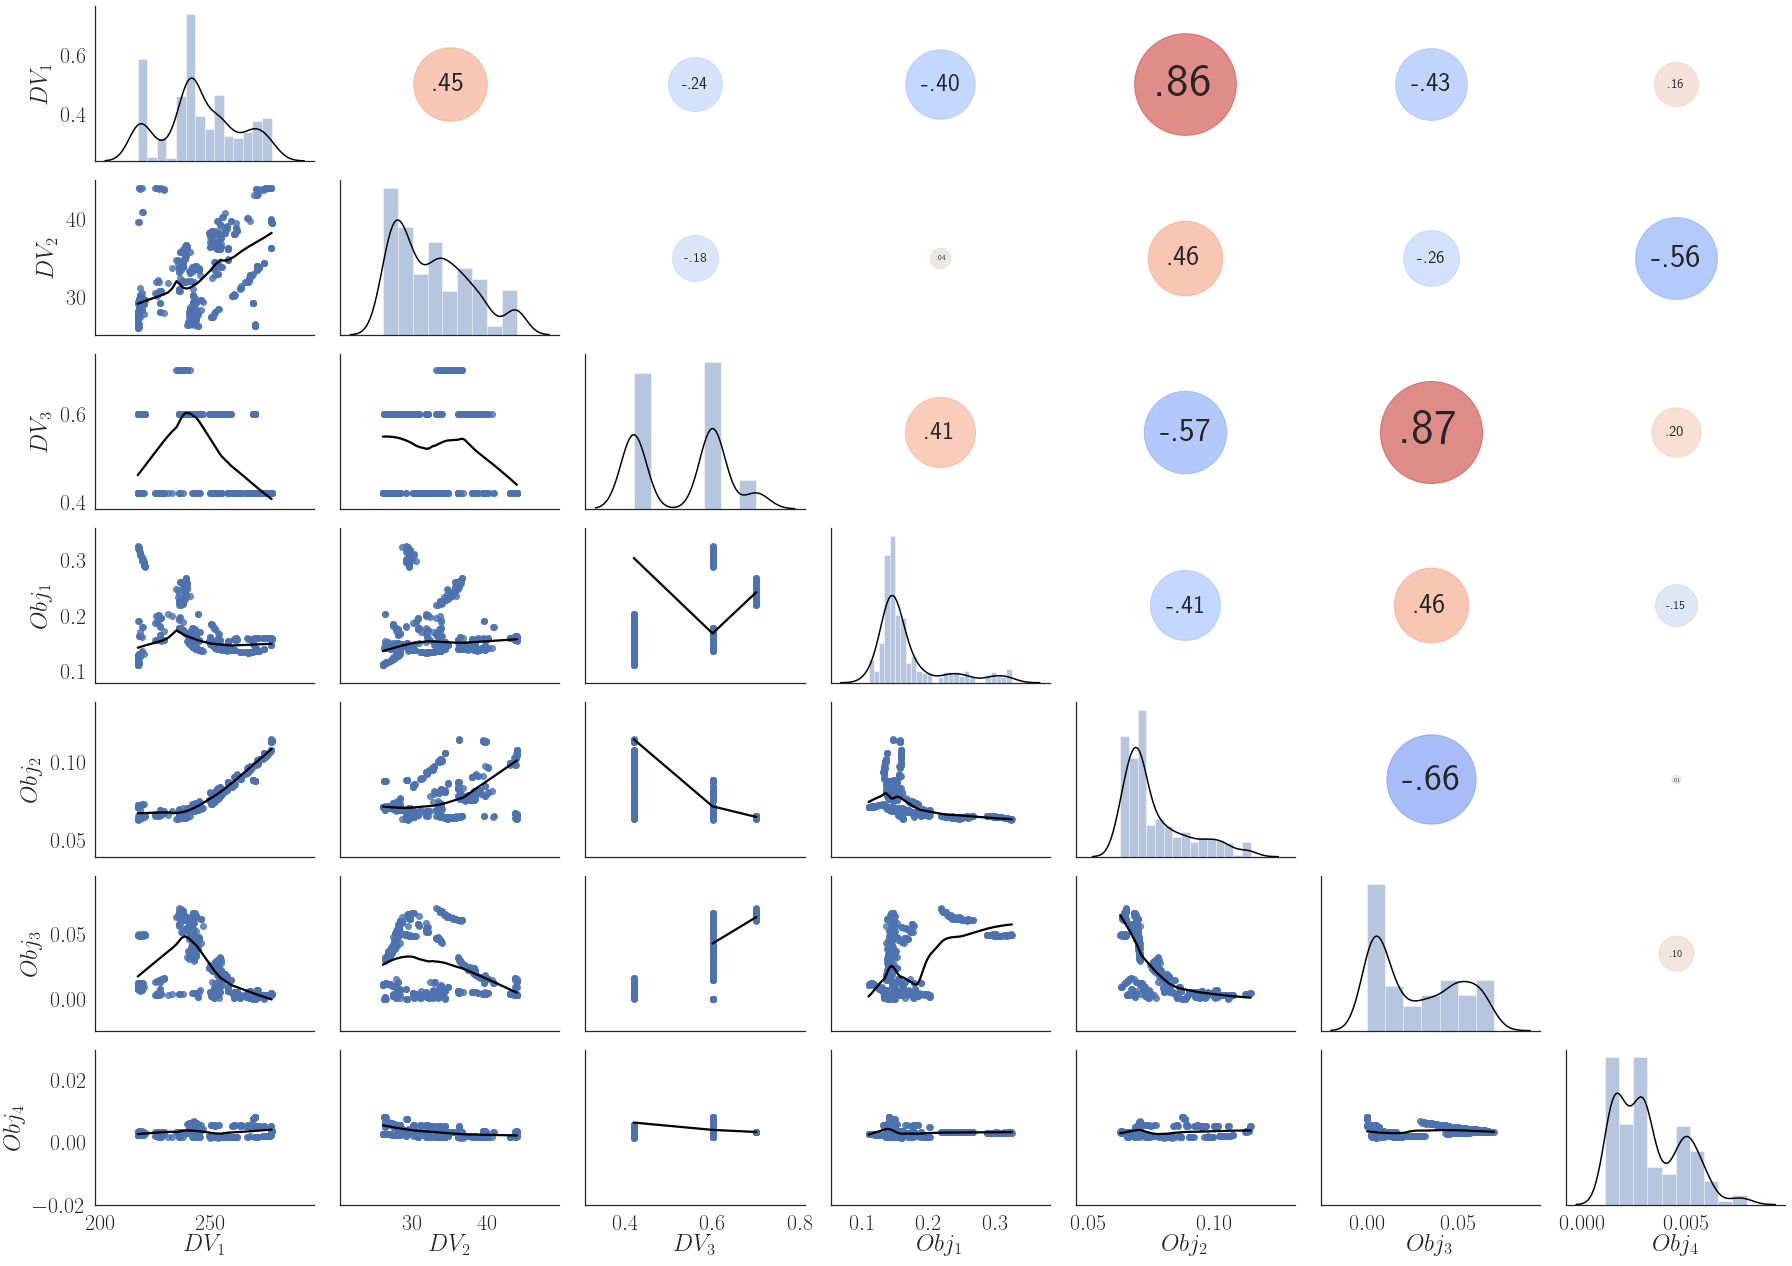

In [47]:
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
# %matplotlib inline

# get the figure
fig = plt.figure()

def corrdot(*args, **kwargs):
    corr_r = args[0].corr(args[1], 'pearson')
    corr_text = f"{corr_r:2.2f}".replace("0.", ".")
    ax = plt.gca()
    ax.set_axis_off()
    marker_size = abs(corr_r) * 12000
    ax.scatter([.5], [.5], marker_size, [corr_r], alpha=0.6, cmap="coolwarm",
               vmin=-1, vmax=1, transform=ax.transAxes)
    font_size = abs(corr_r) * 50 + 5
    ax.annotate(corr_text, [.5, .5,],  xycoords="axes fraction",
                ha='center', va='center', fontsize=font_size)

sns.set(style='white', font_scale=2.0)
# iris = sns.load_dataset('iris')
g = sns.PairGrid(df, aspect=1.4, diag_sharey=False)
g.map_lower(sns.regplot, lowess=True, ci=False, line_kws={'color': 'black'})
g.map_diag(sns.distplot, kde_kws={'color': 'black'})
g.map_upper(corrdot)

In [49]:
filename='Scatter_Corr_matrix'

# save as PDF
fig.savefig("{}.pdf".format(filename), bbox_inches='tight', dpi=300)